# Chapter 12: Least Squares Applications

## Concepts

In [113]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings('ignore')

In [32]:
# Gather Bike Rental Data

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"
data = pd.read_csv(url,sep=',',encoding='unicode_escape')

In [33]:
# Converting string columns to numbers
data["Seasons"].replace(["Spring", "Summer", "Autumn", "Winter"],[1,1,0,0], inplace=True)
data["Holiday"].replace(["Holiday", "No Holiday"],[1,0], inplace=True)
data["Functioning Day"].replace(["Yes", "No"],[1,0], inplace=True)

In [34]:
# EDA
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,1
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,1
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,1
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,1
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,1


In [22]:
# EDA
data.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,0.504110
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,0.500012
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,1.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,1.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000,1.000000


{'Betas': {'Rainfall(mm)': -80.52367456202435, 'Seasons': 369.1266811234558, 'Intercept': 530.4945961502135}}


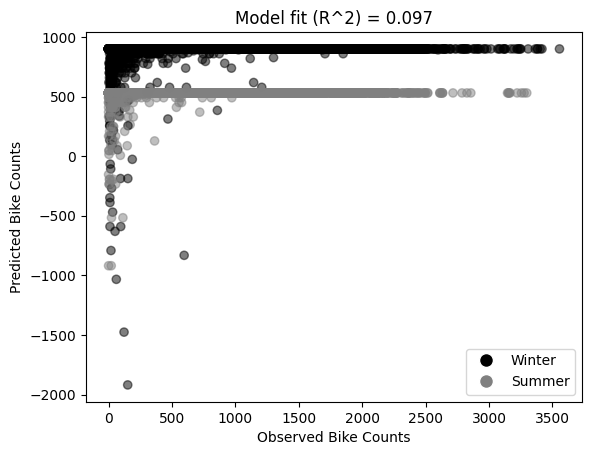

In [94]:
# Fit Bike Rental Data to Linear Regression model using Least Squares in numpy


def fit_and_plot_bike_data(data, feature_columns, target_column, binary_feature=None, binary_labels=None):
    # Extract features and target variable
    features, target_variable = extract_features_and_target(data, feature_columns, target_column)
    
    # Add intercept
    design_matrix = add_intercept(features)
    
    # Fit least squares model
    betas = fit_least_squares(design_matrix, target_variable)
    
    # Print betas
    betas_dict = {feature_columns[i]: betas[i][0] for i in range(len(feature_columns))}
    betas_dict["Intercept"] = betas[-1][0]
    print({"Betas": betas_dict})
    
    # Make predictions
    predictions = design_matrix @ betas
    
    # Calculate R^2
    r2 = calculate_r2(target_variable, predictions)
    
    # Create colors for plot
    colors, binary_colors = create_colors(data, binary_feature, binary_labels)
    
    # Plot results
    plot_results(target_variable, predictions, colors, r2, binary_feature, binary_labels, binary_colors)

def extract_features_and_target(data, feature_columns, target_column):
    features = data[feature_columns].to_numpy()
    target_variable = data[[target_column]].to_numpy()
    return features, target_variable

def add_intercept(features):
    return np.append(features, np.ones(shape=(features.shape[0], 1)), axis=1)

def fit_least_squares(design_matrix, target_variable):
    results = np.linalg.lstsq(design_matrix, target_variable, rcond=None)
    betas = results[0]
    return betas

def calculate_r2(target_variable, predictions):
    ss_total = np.sum((target_variable - np.mean(target_variable)) ** 2)
    ss_residual = np.sum((target_variable - predictions) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

def create_colors(data, binary_feature, binary_labels):
    if binary_feature and binary_labels:
        binary_colors = ["black", "grey"]
        colors = np.where(data[binary_feature].to_numpy() == 1, binary_colors[0], binary_colors[1])
        return colors, binary_colors
    else:
        return 'grey', None

def plot_results(target_variable, predictions, colors, r2, binary_feature, binary_labels, binary_colors):
    plt.scatter(target_variable, predictions, c=colors, alpha=0.5)
    plt.title(f'Model fit (R^2) = {round(r2, 3)}')
    plt.xlabel('Observed Bike Counts')
    plt.ylabel('Predicted Bike Counts')

    if binary_feature and binary_labels:
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=binary_labels[0], markerfacecolor=binary_colors[0], markersize=10),
                           Line2D([0], [0], marker='o', color='w', label=binary_labels[1], markerfacecolor=binary_colors[1], markersize=10)]
        plt.legend(handles=legend_elements, loc='best')

    plt.show()

fit_and_plot_bike_data(
    data, 
    feature_columns=["Rainfall(mm)",  "Seasons"], 
    target_column="Rented Bike Count", 
    binary_feature="Seasons", 
    binary_labels=["Winter", "Summer"]) 

In [44]:
# Fit Bike Rental Data to Linear Regression model using Least Squares in statsmodels

# Create design matrix and target variable
design_matrix = data[["Rainfall(mm)",  "Seasons"]]
target_variable = data[["Rented Bike Count"]]

# Fit data using statsmodels OLS
design_matrix = sm.add_constant(design_matrix)
model = sm.OLS(target_variable, design_matrix).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Rented Bike Count   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     468.8
Date:                Sat, 25 May 2024   Prob (F-statistic):          3.80e-194
Time:                        10:50:56   Log-Likelihood:                -68654.
No. Observations:                8760   AIC:                         1.373e+05
Df Residuals:                    8757   BIC:                         1.373e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          530.4946      9.313     56.963   

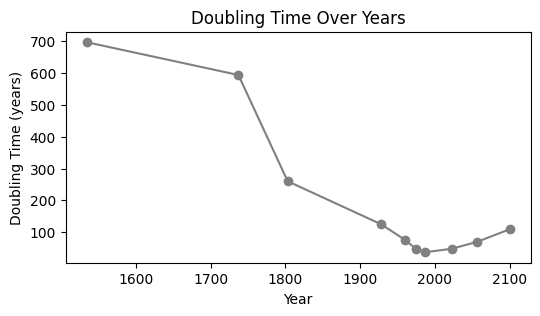

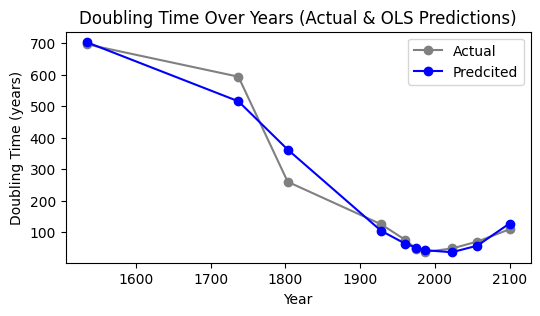

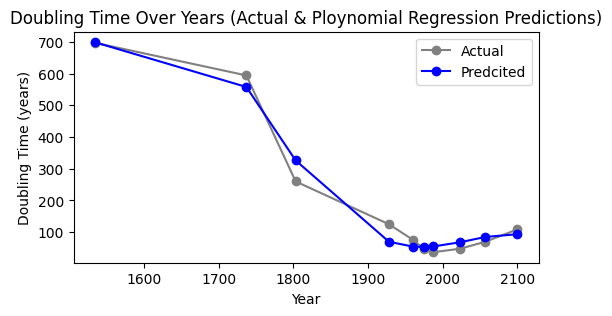

In [65]:
# Fit world population data using polynomial regression via numpy

# define data
year = [1534, 1737, 1803, 1928, 1960, 1975, 1987, 2023, 2057, 2100]
double_time = [697, 594, 260, 125, 76, 47, 37, 48, 70, 109]

# Plot data
plt.figure(figsize=(6, 3))
plt.plot(year, double_time, marker='o', linestyle='-', color='grey')
plt.title('Doubling Time Over Years')
plt.xlabel('Year')
plt.ylabel('Doubling Time (years)')
plt.show()

# Perform Linear regression using numpy lstsq
design_matrix = np.zeros(shape=(10, 4))
for i in range(4):
    design_matrix[:, i] = np.array(year)**i

results = np.linalg.lstsq(design_matrix, double_time, rcond=None)
betas = results[0]

predictions = design_matrix @ betas

# Plot numpy lstsq results
plt.figure(figsize=(6, 3))
plt.plot(year, double_time, marker='o', linestyle='-', color='grey')
plt.plot(year, predictions, marker='o', linestyle='-', color='blue')
plt.title('Doubling Time Over Years (Actual & OLS Predictions)')
plt.xlabel('Year')
plt.ylabel('Doubling Time (years)')
plt.legend(['Actual', 'Predcited'])
plt.show()

# Perform linear regression via numpy polyfit
betas = np.polyfit(year, double_time, deg=4)
predictions = np.polyval(betas, year)

# Plot numpy polyfit results
plt.figure(figsize=(6, 3))
plt.plot(year, double_time, marker='o', linestyle='-', color='grey')
plt.plot(year, predictions, marker='o', linestyle='-', color='blue')
plt.title('Doubling Time Over Years (Actual & Ploynomial Regression Predictions)')
plt.xlabel('Year')
plt.ylabel('Doubling Time (years)')
plt.legend(['Actual', 'Predcited'])
plt.show()

## Code Exercises

{'Betas': {'Rainfall(mm)': -9.829998229145021, 'Seasons': 48.42999142219219, 'Intercept': 152.11692428342974}}


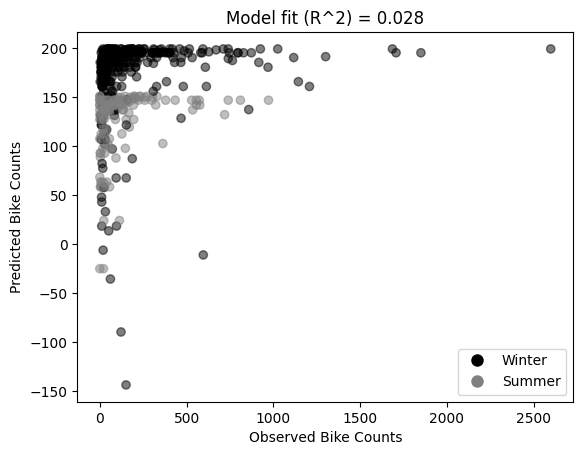

In [96]:
# Exercise 12-1 (Re-fit bike data after eliminating no rainfall instances)

no_rainfall_excluded = data[data['Rainfall(mm)'] != 0]

fit_and_plot_bike_data(
    no_rainfall_excluded, 
    feature_columns=["Rainfall(mm)",  "Seasons"], 
    target_column="Rented Bike Count", 
    binary_feature="Seasons", 
    binary_labels=["Winter", "Summer"]) 

{'Betas': {'Rainfall(mm)': -86.06170760812999, 'Temperature(°C)': 29.48981802920288, 'Intercept': 337.483293877251}}


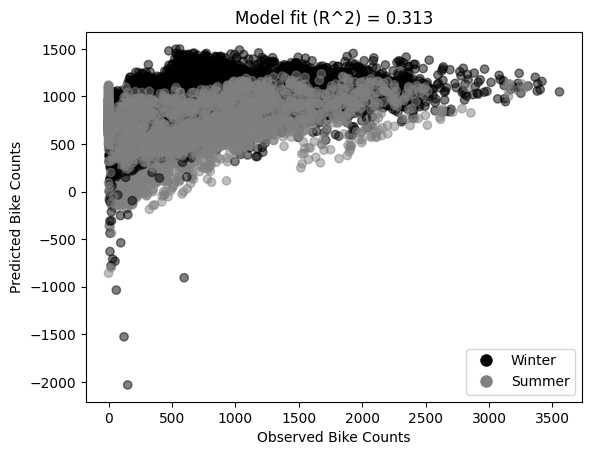

In [99]:
# Exercise 12-2 (Re-fit bike data after replacing seasons with temperature data)

fit_and_plot_bike_data(
    data, 
    feature_columns=["Rainfall(mm)",  "Temperature(°C)"], 
    target_column="Rented Bike Count", 
    binary_feature="Seasons", 
    binary_labels=["Winter", "Summer"]) 

In [144]:
# Exercise 12-3 (Re-fit bike data after creating new feature that is a linear combination of temperature and rainfall)

modified_data = data.copy()
weights = np.random.rand(2)
modified_data["Temp Rainfall Combo"] = (modified_data["Temperature(°C)"] * weights[0]) + (modified_data["Rainfall(mm)"] * weights[1])

features = modified_data[["Temperature(°C)", "Rainfall(mm)", "Temp Rainfall Combo"]].to_numpy()
design_matrix = np.append(features, np.ones(shape=(features.shape[0], 1)), axis=1)
target_variable = modified_data[["Rented Bike Count"]].to_numpy()

print("Design Matrix Size:", design_matrix.shape)
print("Design Matrix Rank:", np.linalg.matrix_rank(design_matrix))
print("Design Matrix correlation matrix:", "\n", np.corrcoef(design_matrix.T), "\n")

# Left-inverse
design_matrix_leftinv = np.linalg.inv(design_matrix.T @ design_matrix) @ design_matrix.T
left_inverse_betas = design_matrix_leftinv @ target_variable
left_inverse_predictions = design_matrix @ betas
left_inverse_r2 = calculate_r2(target_variable, left_inverse_predictions)

# Numpy lstqr
results = np.linalg.lstsq(design_matrix, target_variable, rcond=None)
np_lstqr_betas = results[0]
np_lstqr_predictions = design_matrix @ np_lstqr_betas
np_lstqr_r2 = calculate_r2(target_variable, np_lstqr_predictions)

# Statsmodels
design_matrix = sm.add_constant(design_matrix)
model = sm.OLS(target_variable, design_matrix).fit()
statsmodels_betas = model.params
statsmodels_r2 = model.rsquared

print("MODEL FIT TO DATA:")
print("Left-inverse:", round(left_inverse_r2, 4))
print("np lstqr:", round(np_lstqr_r2, 4))
print("statsmodels:", round(statsmodels_r2, 4), "\n")

print("BETA COEFFICIENTS:")
print("Left-inverse:", np.around(left_inverse_betas.T, 2))
print("np lstqr:", np.around(np_lstqr_betas.T,  2))
print("statsmodels:", np.around(statsmodels_betas.T,  2))

Design Matrix Size: (8760, 4)
Design Matrix Rank: 3
Design Matrix correlation matrix: 
 [[1.         0.05028186 0.97533511        nan]
 [0.05028186 1.         0.26949175        nan]
 [0.97533511 0.26949175 1.                nan]
 [       nan        nan        nan        nan]] 

MODEL FIT TO DATA:
Left-inverse: 0.2392
np lstqr: 0.3126
statsmodels: 0.3126 

BETA COEFFICIENTS:
Left-inverse: [[  13.88 -129.46   78.58  337.48]]
np lstqr: [[ 35.61 -71.21 -28.97 337.48]]
statsmodels: [ 35.61 -71.21 -28.97 337.48]


In [145]:
# Exercise 12-4 (Experiment with regularization effects on outcomes)

# regularization parameter
gamma = .01

# regularization paramater multiplied by matrix frobenius norm
gamnorm = gamma * np.linalg.norm(design_matrix,'fro')**2

# inverse of (X'X+lI)
leftinv = np.linalg.inv(design_matrix.T @ design_matrix + gamnorm * np.eye(design_matrix.shape[1]))

# Print left-inverse size & rank
print(f"inv(X'X + {gamma}*I) size: {leftinv.shape}")
print(f"inv(X'X + {gamma}*I) rank: {np.linalg.matrix_rank(leftinv)}")

inv(X'X + 0.01*I) size: (4, 4)
inv(X'X + 0.01*I) rank: 4


In [ ]:
# Exercise 12-5 (Polynomial regression with varying orders)

In [ ]:
# Exercise 12-6 (Perform Grid Search to find parameters for Linear Regression)

In [ ]:
# Exercise 12-7 (Evaluating Linear Regression using R^2)